In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import os
import cv2

import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np

from random import randint

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers
from sklearn.metrics import confusion_matrix

In [3]:
CLASSES, gems = [], []

for root, dirs, files in os.walk('./gdrive/My Drive/Dataset/archive'):
    f = os.path.basename(root)
        
    if len(files) > 0:
        gems.append(len(files))
        if f not in CLASSES:
            CLASSES.append(f)
    
gems_count = len(CLASSES)
print('{} classes with {} images in total'.format(len(CLASSES), sum(gems)))

88 classes with 3228 images in total


In [4]:
img_w, img_h = 220, 220    # width and height of image
train_dir = './gdrive/My Drive/Dataset/archive/train/'

In [5]:
def read_imgs_lbls(_dir):
    Images, Labels = [], []
    for root, dirs, files in os.walk(_dir):
        f = os.path.basename(root)  # get class name - Amethyst, Onyx, etc       
        for file in files:
            try:
              image = cv2.imread(root+'/'+file)              # read the image (OpenCV)
              image = cv2.resize(image, (int(img_w*1.5), int(img_h*1.5)), interpolation=cv2.INTER_AREA)      # resize the image (images are different sizes)
              image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # converts an image from BGR color space to RGB
              Images.append(image)
              Labels.append(f)
            except Exception as e:
              print()
    Images = np.array(Images)
    return (Images, Labels)

In [6]:
def get_class_index(Labels):
    for i, n in enumerate(Labels):
        for j, k in enumerate(CLASSES):
            if n == k:
                Labels[i] = j
    Labels = np.array(Labels)
    return Labels

In [7]:
Train_Imgs, Train_Lbls = read_imgs_lbls(train_dir)
Train_Lbls = get_class_index(Train_Lbls)
print('Shape of train images: {}'.format(Train_Imgs.shape))
print('Shape of train labels: {}'.format(Train_Lbls.shape))


Shape of train images: (2856, 330, 330, 3)
Shape of train labels: (2856,)


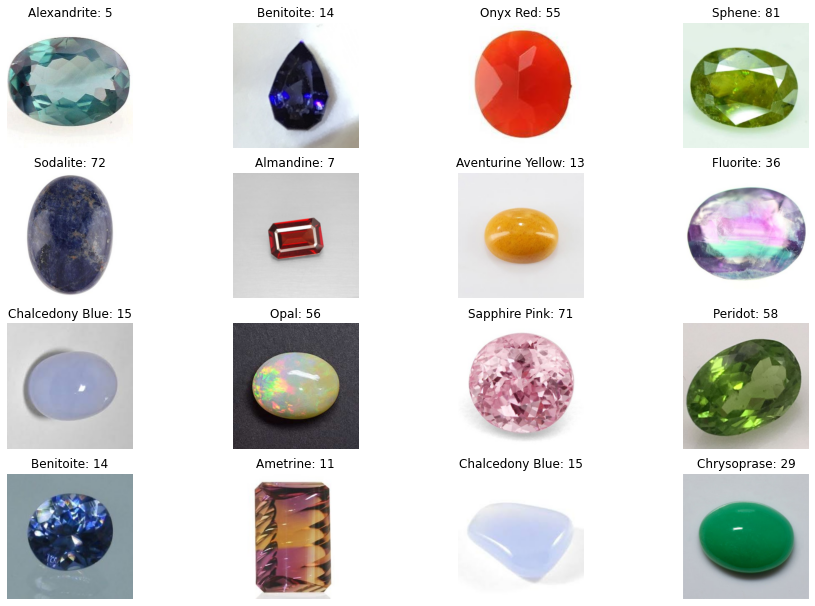

In [8]:
dim = 4

f,ax = plt.subplots(dim,dim) 
f.subplots_adjust(0,0,2,2)
for i in range(0,dim):
    for j in range(0,dim):
        rnd_number = randint(0,len(Train_Imgs))
        cl = Train_Lbls[rnd_number]
        ax[i,j].imshow(Train_Imgs[rnd_number])
        ax[i,j].set_title(CLASSES[int(cl)]+': ' + str(cl))
        ax[i,j].axis('off')

In [9]:
def edge_and_cut(img):
    try:
        edges = cv2.Canny(img, img_w, img_h)            
        
        if(np.count_nonzero(edges)>edges.size/10000):           
            pts = np.argwhere(edges>0)
            y1,x1 = pts.min(axis=0)
            y2,x2 = pts.max(axis=0)
            
            new_img = img[y1:y2, x1:x2]           # crop the region
            new_img = cv2.resize(new_img,(img_w, img_h))  # Convert back
        else:
            new_img = cv2.resize(img,(img_w, img_h))
    
    except Exception as e:
        print(e)
        new_img = cv2.resize(img,(img_w, img_h))
    
    return new_img

In [10]:
def show_cropped(img):
    emb_img = img.copy()
    edges = cv2.Canny(img, img_w, img_h)
    
    if(np.count_nonzero(edges)>edges.size/10000):
        pts = np.argwhere(edges>0)
        y1,x1 = pts.min(axis=0)
        y2,x2 = pts.max(axis=0)

        new_img = img[y1:y2, x1:x2]  

        edge_size = 1 #replace it with bigger size for larger images            

        emb_img[y1-edge_size:y1+edge_size, x1:x2] = [255, 0, 0]
        emb_img[y2-edge_size:y2+edge_size, x1:x2] = [255, 0, 0]
        emb_img[y1:y2, x1-edge_size:x1+edge_size] = [255, 0, 0]
        emb_img[y1:y2, x2-edge_size:x2+edge_size] = [255, 0, 0]

        new_img = cv2.resize(new_img,(img_w, img_h))  # Convert to primary size  
        
    else:
        new_img = cv2.resize(img,(img_w, img_h))
    
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10, 10))
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title('Original Image', fontsize=14)
    ax[1].imshow(edges, cmap='gray')
    ax[1].set_title('Canny Edges', fontsize=14)
    ax[2].imshow(emb_img, cmap='gray')
    ax[2].set_title('Bounding Box', fontsize=14)       
    ax[3].imshow(new_img, cmap='gray')
    ax[3].set_title('Cropped', fontsize=14) 

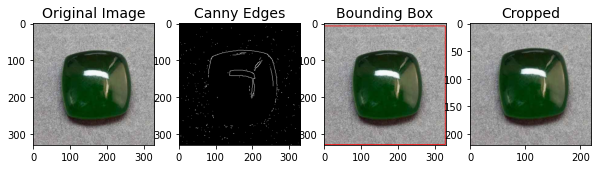

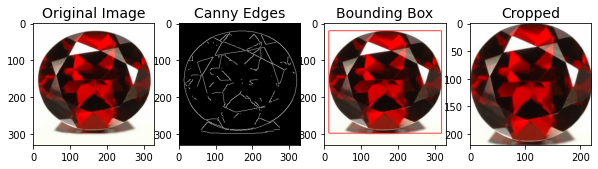

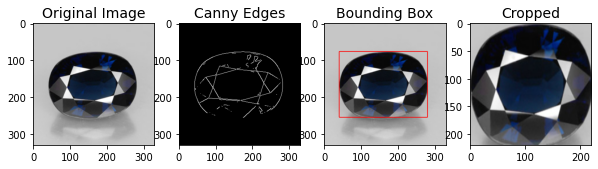

In [11]:
for x in range(0,3):
    show_cropped(Train_Imgs[randint(0,len(Train_Imgs))])

In [12]:
def crop_images(Imgs):
    CroppedImages = np.ndarray(shape=(len(Imgs), img_w, img_h, 3), dtype=np.int)

    ind = 0
    for im in Imgs: 
        x = edge_and_cut(im)
        CroppedImages[ind] = x
        ind += 1

    return CroppedImages

In [13]:
Train_Imgs = crop_images(Train_Imgs)
print('Final shape of images in train set: {} '.format(Train_Imgs.shape))

Final shape of images in train set: (2856, 220, 220, 3) 


In [14]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(Train_Imgs, Train_Lbls, shuffle = True, test_size = 0.2, random_state = 42)
print('Shape of X_train: {}, y_train: {} '.format(X_train.shape, y_train.shape))
print('Shape of X_val: {}, y_val: {} '.format(X_val.shape, y_val.shape))

Shape of X_train: (2284, 220, 220, 3), y_train: (2284,) 
Shape of X_val: (572, 220, 220, 3), y_val: (572,) 


In [15]:
filters = 32
kernel_size = 3
max_pool = 2 
EPOCHS = 1
batch_size = 32
iter_per_epoch = len(X_train) // batch_size
val_per_epoch = len(X_val) // batch_size

In [16]:
myModel = Sequential()

myModel.add(Conv2D(batch_size, (kernel_size, kernel_size), activation='relu', padding='same', input_shape=(img_w, img_h, 3)))
myModel.add(MaxPooling2D((max_pool, max_pool)))

myModel.add(Conv2D(2*batch_size, (kernel_size, kernel_size), activation='relu', padding='same'))
myModel.add(MaxPooling2D((max_pool, max_pool))) 

myModel.add(Conv2D(4*batch_size, (kernel_size, kernel_size), activation='relu', padding='same'))
myModel.add(MaxPooling2D((max_pool, max_pool))) 

myModel.add(Conv2D(4*batch_size, (kernel_size, kernel_size), activation='relu', padding='same'))
myModel.add(AveragePooling2D(pool_size= (2, 2), strides= (2, 2))) 

myModel.add(Conv2D(4*batch_size, (kernel_size, kernel_size), activation='relu', padding='same'))
myModel.add(MaxPooling2D((max_pool, max_pool))) 

myModel.add(Flatten())
myModel.add(Dropout(0.5))
myModel.add(Dense(16*batch_size, activation='relu'))
myModel.add(Dense(87, activation='softmax'))
myModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 220, 220, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 110, 110, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 55, 55, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 27, 27, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 27, 128)       1

In [17]:
myModel.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [18]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rotation_range=25,
        zoom_range=0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        horizontal_flip=True
        )

val_datagen = ImageDataGenerator()  

In [19]:
trainGenerate = train_datagen.flow(X_train, y_train, batch_size=batch_size)
validateGenerate = val_datagen.flow(X_val, y_val, batch_size=batch_size)

In [21]:
myModel.fit(
       trainGenerate,
       steps_per_epoch = len(trainX) // 32,
       epochs = 10, 
       validation_data = validateGenerate,
       validation_steps = len(validateX) // 32,
       verbose = 1
)

NameError: ignored

In [ ]:
score = model.evaluate(val_gen, steps= len(val_gen))

for idx, metric in enumerate(model.metrics_names):
    print('{}:{}'.format(metric, score[idx]))

In [ ]:
y_pre_test=model.predict(X_val)
y_pre_test=np.argmax(y_pre_test,axis=1)
cm=confusion_matrix(y_val,y_pre_test)

plt.figure(figsize = (15,15))
sn.heatmap(cm, annot=True)